### BatchNorm

In [1]:
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input, Dropout, BatchNormalization, Activation
from keras_vggface.vggface import VGGFace
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface import utils
from keras.optimizers import Adam
from keras.preprocessing import image
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

/home/gloria/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/gloria/tensorflow/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Constants
IMG_SIZE = 200
IMG_DIR = '../project/all_females'
RATING_PATH = './ratings_stefan.txt'

### Build model

In [3]:
# Read in ratings
ratings = np.genfromtxt(RATING_PATH)
scaler = StandardScaler()

### Distribute images across folders
if not os.path.isdir('./data/train/train'):
    os.makedirs('./data/train/train')
if not os.path.isdir('./data/test/test'):
    os.makedirs('./data/test/test')
        
### Move all images according to ratings
images = sorted(os.listdir(IMG_DIR))

### Make sure lengths of ratings and images correspond 
assert len(ratings) == len(images)

X_train, X_test, y_train, y_test = train_test_split(images, ratings, test_size=0.2)

y_train = scaler.fit_transform(y_train.reshape(-1,1))
y_test = scaler.transform(y_test.reshape(-1,1))
    
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
        
print("Train-test-split:")
print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

data_train = np.zeros((X_train.shape[0], IMG_SIZE, IMG_SIZE, 3))
data_test = np.zeros((X_test.shape[0], IMG_SIZE, IMG_SIZE, 3))

for idx, _im in enumerate(X_train):
    # Change the image path with yours.
    _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
    _x = image.img_to_array(_img)
    _x = np.expand_dims(_x, axis=0)
    data_train[idx, :, :, :] = utils.preprocess_input(_x, version=1) / .255 
    
# Same for test data
for idx, _im in enumerate(X_test):   
    _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
    _x = image.img_to_array(_img)
    _x = np.expand_dims(_x, axis=0)
    data_test[idx, :, :, :] = utils.preprocess_input(_x, version=1) / .255

### Loop throgh all images and store them in the dedicated folders
#for img in X_train:
#    src = os.path.join(IMG_DIR, img)
#    dest = os.path.join('./data/train/train', img)
#    shutil.copy(src, dest)

#for img in X_test:
#    src = os.path.join(IMG_DIR, img)
#    dest = os.path.join('./data/test/test', img)
#    shutil.copy(src, dest)

Train-test-split:
X_train:  (454,)
X_test:  (114,)
y_train:  (454, 1)
y_test:  (114, 1)


In [4]:
K.clear_session()

vgg_base = VGGFace(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='max')

# Add custom layers
last_layer = vgg_base.get_layer('global_max_pooling2d_1').output
#X = Dropout(0.2)(last_layer)
X = Dense(256, activation=None, name='fc6')(last_layer)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(0.2)(X)
X = Dense(128, activation=None, name='fc7')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(0.2)(X)
X = Dense(64, activation=None, name='fc8')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(0.2)(X)
#output = Dense(len(np.unique(ratings)), activation=None)(X)

output = Dense(1, activation='linear')(X)
output = BatchNormalization()(output)

# this is the model we will train
model = Model(inputs=vgg_base.input, outputs=output)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in vgg_base.layers:
    layer.trainable = False

# Make sure weights are not trainable
print("Trainable weights:")
model.trainable_weights

model.compile(optimizer=Adam(clipnorm=1.0),loss='mean_absolute_error', metrics=['mae'])

model.summary()

Trainable weights:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 200, 200, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 200, 200, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 100, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 100, 100, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 100, 100, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 50, 128)       0 

### Prepare data
### **Please remember to delete the train & test folders if you have run this cell before!**

### Data augmentation

In [5]:
datagen = ImageDataGenerator(rescale=1./255, 
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             preprocessing_function=utils.preprocess_input)

datagen.fit(data_train)

#train_generator = datagen.flow_from_directory(
#    './data/train',
#    target_size=(IMG_SIZE, IMG_SIZE),
#    batch_size=64,
#    class_mode=None
#)

test_datagen = ImageDataGenerator(rescale=1./255)

test_datagen.fit(data_test)

#test_generator = test_datagen.flow_from_directory(
#    './data/test',
#    target_size=(IMG_SIZE, IMG_SIZE),
#    batch_size=64,
#    class_mode=None
#)

### Train

In [6]:
checkpointer = ModelCheckpoint(filepath='./weights-v4.4.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

history = model.fit_generator(
    datagen.flow(data_train, y_train, batch_size=64),
    steps_per_epoch=100,
    epochs=1,
    validation_data=test_datagen.flow(data_test, y_test, batch_size=64),
    callbacks=[checkpointer]
)

Epoch 1/1
100/100 [==============================] - 68s 684ms/step - loss: 0.6999 - mean_absolute_error: 0.6999 - val_loss: 0.6891 - val_mean_absolute_error: 0.6891

Epoch 00001: val_loss improved from inf to 0.68913, saving model to ./weights-v4.4.hdf5


In [7]:
history = model.fit_generator(
    datagen.flow(data_train, y_train, batch_size=64),
    steps_per_epoch=453//64,
    epochs=500,
    validation_data=test_datagen.flow(data_test, y_test, batch_size=64),
    callbacks=[earlystop, checkpointer]
)

Epoch 1/500
7/7 [==============================] - 6s 804ms/step - loss: 0.5182 - mean_absolute_error: 0.5182 - val_loss: 0.7248 - val_mean_absolute_error: 0.7248

Epoch 00001: val_loss did not improve
Epoch 2/500
7/7 [==============================] - 6s 832ms/step - loss: 0.5401 - mean_absolute_error: 0.5401 - val_loss: 0.7032 - val_mean_absolute_error: 0.7032

Epoch 00002: val_loss did not improve
Epoch 3/500
7/7 [==============================] - 5s 715ms/step - loss: 0.5000 - mean_absolute_error: 0.5000 - val_loss: 0.6838 - val_mean_absolute_error: 0.6838

Epoch 00003: val_loss improved from 0.68913 to 0.68381, saving model to ./weights-v4.4.hdf5
Epoch 4/500
7/7 [==============================] - 6s 835ms/step - loss: 0.5107 - mean_absolute_error: 0.5107 - val_loss: 0.6657 - val_mean_absolute_error: 0.6657

Epoch 00004: val_loss improved from 0.68381 to 0.66570, saving model to ./weights-v4.4.hdf5
Epoch 5/500
7/7 [==============================] - 6s 796ms/step - loss: 0.5068 - me

In [8]:
model.save('./models/love_classifierv4.4.h5')

### Choose candidates from test set

In [9]:
#freeze layers
#for layer in model.layers:
#    layer.trainable = False

candidates = data_test
candidates = np.expand_dims(candidates, axis=0)
predictions = np.zeros(candidates.shape[1])

for i in range(candidates.shape[1]):
    predictions[i] = model.predict(candidates[:,i])

#sort predictions
predictions = predictions[np.argsort(predictions)]
print(predictions)

[-1.30603897e+02 -7.77688446e+01 -7.51976166e+01 -7.37438431e+01
 -7.21321335e+01 -7.18155975e+01 -7.11794968e+01 -7.07703018e+01
 -7.05641861e+01 -6.58607788e+01 -6.22999191e+01 -5.95874557e+01
 -5.80118217e+01 -5.66818085e+01 -5.48119774e+01 -5.47985764e+01
 -5.45143204e+01 -5.38707275e+01 -5.18210411e+01 -4.97907600e+01
 -4.54389725e+01 -4.52457428e+01 -4.48418503e+01 -4.22386475e+01
 -3.61133461e+01 -3.10839939e+01 -2.78480530e+01 -2.59762039e+01
 -2.49202023e+01 -2.43456879e+01 -2.41196404e+01 -2.32970123e+01
 -2.26207829e+01 -2.21055794e+01 -2.05534344e+01 -1.22039595e+01
 -1.18609762e+01 -1.14593697e+01 -9.55608368e+00 -9.35750675e+00
 -8.76347542e+00 -8.26890469e+00 -5.62944698e+00 -4.97597218e+00
 -3.78573322e+00 -2.38706589e-01  4.04343510e+00  5.05656624e+00
  6.35721970e+00  7.34578514e+00  7.76203918e+00  9.03803635e+00
  9.36683750e+00  1.01089840e+01  1.11293888e+01  1.16313591e+01
  1.23058205e+01  1.23668547e+01  1.28655720e+01  1.49430637e+01
  1.72300644e+01  1.75389

### ^ Output for regression should be between 0 & 5. Need to change activation of last layer, see v4.1.

In [10]:
print(y_test)

[[-0.32478986]
 [ 1.43633997]
 [-0.64499529]
 [-1.20535478]
 [ 0.31562099]
 [ 1.1961859 ]
 [-0.96520071]
 [-0.88514935]
 [-0.88514935]
 [ 0.07546692]
 [-0.40484122]
 [-1.12530342]
 [-0.16468715]
 [-0.64499529]
 [ 1.83659675]
 [-1.12530342]
 [-0.96520071]
 [ 1.51639132]
 [-0.805098  ]
 [-0.16468715]
 [-1.36545749]
 [ 1.35628861]
 [-0.48489257]
 [-1.04525207]
 [ 1.75654539]
 [ 0.71587776]
 [-0.32478986]
 [-1.12530342]
 [-0.16468715]
 [-0.00458444]
 [-1.44550885]
 [-0.96520071]
 [ 1.83659675]
 [-0.08463579]
 [ 1.99669946]
 [ 2.15680217]
 [-0.56494393]
 [-0.40484122]
 [ 0.71587776]
 [-1.28540613]
 [-0.72504664]
 [-0.72504664]
 [-1.36545749]
 [ 0.87598048]
 [-0.32478986]
 [ 0.55577505]
 [ 0.15551827]
 [ 0.07546692]
 [-0.72504664]
 [-0.56494393]
 [-0.24473851]
 [ 1.9166481 ]
 [-1.12530342]
 [ 0.4757237 ]
 [ 0.95603183]
 [ 0.4757237 ]
 [-1.28540613]
 [ 1.35628861]
 [ 1.03608319]
 [ 1.11613454]
 [-0.48489257]
 [ 1.59644268]
 [-0.48489257]
 [ 0.87598048]
 [-0.96520071]
 [ 0.95603183]
 [ 1.35628

In [17]:
def visualize_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'bo-', label="Training loss")
    plt.plot(epochs, val_loss, 'b', label="Validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def visualize_mae(history):
    loss = history.history['mean_absolute_error']
    val_loss = history.history['val_mean_absolute_error']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'ro-', label="Training MAE")
    plt.plot(epochs, val_loss, 'r', label="Validation MAE")
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

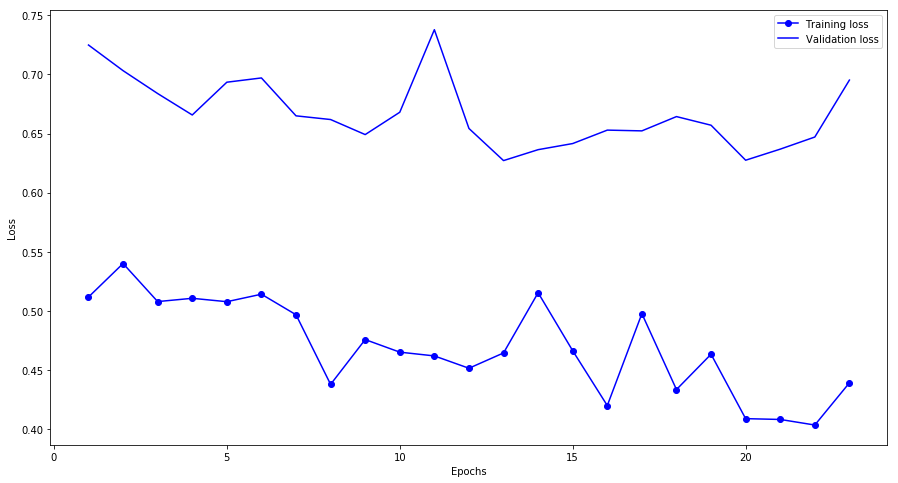

In [12]:
visualize_loss(history)

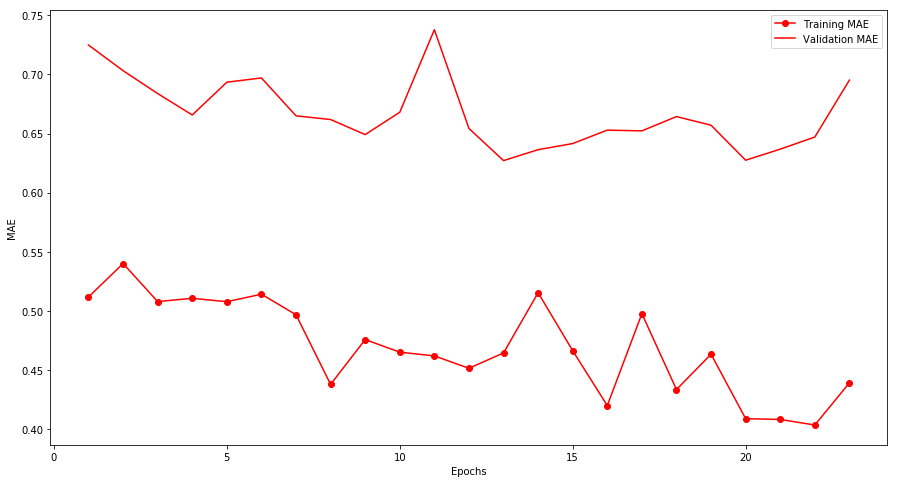

In [18]:
visualize_mae(history)